# Content

In this notebook, we will train a Character level Language model using Transformer Decoder.

Character level means that instead of generating complete WORDS(or a complete word at a time) like in a word level LM, our model will learn to generate individual characters(one single character at a time).

This approach have a few benefits over word level LM, like:

1. Smaller vocabulary size: Instead of our vocabulary size consisting of all unique word of the corpus, it simply consists of unique characters
2. Easier tokenization: The tokenization simply consists of breaking down the text into characters

For our model, we will use the Tiny Shakespeare dataset. It consists of a single text file containing a selection of works by William Shakespeare, specifically his plays.


In [1]:
from IPython.display import clear_output

In [2]:
# %pip install numpy matplotlib torch tqdm requests

clear_output()

In [3]:
import math

import random
import requests

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

## Loading the data

In [4]:
# Load the dataset
dataset_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
shakespeare_text = requests.get(dataset_url).text

In [5]:
# Create a mapping from character to index and vice versa

unique_chars = sorted(list(set(shakespeare_text)))
vocab_size = len(unique_chars)
char_to_idx = {char: idx for idx, char in enumerate(unique_chars)}
idx_to_char = {idx: char for idx, char in enumerate(unique_chars)}

In [6]:
# Encode the dataset into integer indices

encoded_sp_text = torch.Tensor([char_to_idx[char] for char in tqdm(shakespeare_text)]).type(torch.long)

100%|██████████| 1115394/1115394 [00:00<00:00, 7178854.46it/s]


In [7]:
encoded_sp_text.shape

torch.Size([1115394])

In [8]:
def encode(text):
    encoded_txt = [char_to_idx[char] for char in text]
    return encoded_txt

def decode(encoded_seq):
    decoded_text = ''.join([idx_to_char[idx] for idx in encoded_seq])
    return decoded_text

## Defining the dataset class

In [170]:
class ShakeSpeareCharactersDataset(Dataset):

    def __init__(self, encoded_sp_text, seq_len=100):

        self.encoded_sp_text = encoded_sp_text
        self.seq_len = seq_len

    def __len__(self):
        # We will randomly sample parts of text in this dataset and return them so we don't have a specific length, so we can define it anything.
        # Note that this length will be used as number of samples per epoch. Increasing this will increase the number of samples processed per epoch.
        return 15000

    def __getitem__(self, idx):

        start_idx = random.randint(0, len(self.encoded_sp_text) - self.seq_len)
        end_idx = start_idx + self.seq_len

        # calling torch.Tensor on a value that's already possibly tensor because:
        # 1. If it's not a tensor, it'll be converted to one
        # 2. If it's already a tensor, It's safer to make a copy of it and this will do just that.
        text = torch.Tensor(self.encoded_sp_text[start_idx:end_idx])
        return text


In [171]:
train_dataset = ShakeSpeareCharactersDataset(encoded_sp_text, seq_len=100)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## Defining the model

In [190]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length=200):
        super(PositionalEncoding, self).__init__()
        self.register_buffer('pe', self._get_positional_encoding(max_seq_length, d_model))

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

    def _get_positional_encoding(self, max_seq_length, d_model):
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Add batch dimension
        return pe


# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, num_heads, num_layers, dropout):
        super(TransformerModel, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.pe = PositionalEncoding(embedding_size)

        self.decoder_layer = nn.TransformerDecoderLayer(embedding_size, num_heads, dropout=dropout, batch_first=True)
        self.transformer_decoder = nn.TransformerDecoder(self.decoder_layer, num_layers)
        self.fc = nn.Linear(embedding_size, vocab_size)
    
    def forward(self, src, mask=None):
        src = self.embedding(src)

        src = self.pe(src)

        output = self.transformer_decoder(src,
                                          torch.ones_like(src),
                                          tgt_mask=mask,
                                          tgt_is_causal=(True if mask is not None else False))
        output = self.fc(output)
        return output

## Training the model

In [201]:
# Hyperparameters
batch_size = 64
embedding_size = 128
num_heads = 8
num_layers = 4
dropout = 0.1
num_epochs = 70
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [202]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [220]:
# Model, Loss, Optimizer
learning_rate = 1e-3
min_lr = 1e-4

model = TransformerModel(vocab_size, embedding_size, num_heads, num_layers, dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5, min_lr=min_lr, threshold=1e-3)

In [221]:
train_losses = []

In [240]:
optimizer.param_groups[0]['lr'] = 1e-5

In [ ]:
# Training loop
for epoch in range(num_epochs):

    model.train()

    epoch_losses = []

    for encoded_text_batch in tqdm(train_loader):

        encoded_text_batch = encoded_text_batch.to(device)

        inputs, targets = encoded_text_batch[..., :-1], encoded_text_batch[..., 1:]
        # mask = nn.Transformer.generate_square_subsequent_mask(inputs.shape[-1]).unsqueeze(0).to(inputs.device)
        mask = nn.Transformer.generate_square_subsequent_mask(inputs.shape[-1]).to(inputs.device)
        # mask = None

        # Forward pass
        outputs = model(inputs, mask)

        outputs = outputs.reshape(-1, vocab_size)
        targets = targets.reshape(-1)

        loss = criterion(outputs, targets)

        epoch_losses.append(loss.item())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = sum(epoch_losses) / len(epoch_losses)

    scheduler.step(epoch_loss)
    train_losses.append(epoch_loss)

    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {(epoch_loss):.4f}')

    t_outputs = torch.argmax(outputs.detach().cpu(), dim=-1).tolist()

In [242]:
outputs.shape

torch.Size([6336, 65])

In [243]:
outputs.shape

torch.Size([6336, 65])

In [244]:
optimizer.param_groups[0]['lr']

1e-05

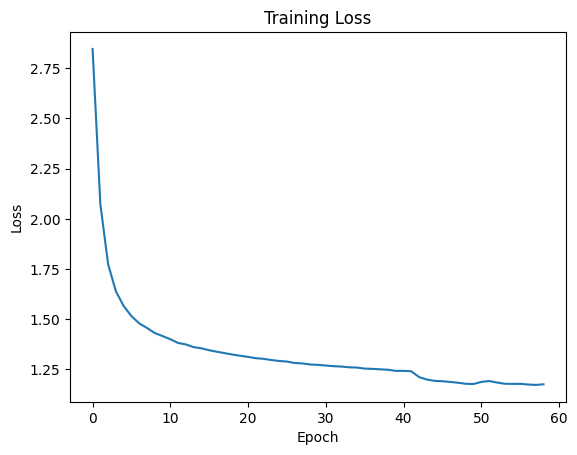

In [245]:
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

## Testing the model

In [246]:
# Function to generate text
def generate_text(model, start_text, length):
    model.eval()
    input_seq = torch.tensor(encode(start_text), dtype=torch.long).unsqueeze(0).to(device)
    generated_seq = input_seq.tolist()[0]

    for _ in range(length):
        with torch.no_grad():
            output = model(input_seq)
            next_char = torch.argmax(output[:, -1, :], dim=-1).item()
            generated_seq.append(next_char)
            input_seq = torch.cat([input_seq, torch.tensor([[next_char]], device=device)], dim=1)

    return decode(generated_seq)

In [251]:
# Example generation
start_str = "To be or not"
generated_text = generate_text(model, start_str, 100)
print(generated_text)

To be or noth there throw there throw
That the pardon there thing thereth his seenses.

Provident, tho tho tho t
